# Exploring the Circumgalactic medium of an Average LAE in HETDEX
This notebook showcases the fiber spectra extraction & analysis on the Circumgalactic medium on Lyman Alpha Emitters through studying the HI gas. The goal here is to select a number of LAE detections, specify a region around each LAE, extract all the fibers in that region, and stack those fibers so that you can study the prominent feautres in the spectra. The major feature that I fucosed on in this work has been the Lyman Alpha Absorption line, which would give me an estimate of the column density of the HI gas through UV background absorption. Note that since this absorption is prettty weak, this analysis would only work when you have a large number of LAEs ~1000 detects. This is the only way you would get a feasible signal to noise ratio.

In [5]:
import sys
import os
import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
import hetdex_api
from hetdex_api.shot import *
from hetdex_api.extract import Extract
import time
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from hetdex_api.shot import get_fibers_table
from hetdex_api.survey import FiberIndex
import numpy as np
from hetdex_api.config import HDRconfig
from elixer import spectrum_utilities as SU
import tables
from astropy.table import QTable, Table, Column
from tqdm import tqdm
from elixer import global_config as G
from multiprocessing import Pool
import pickle
from hetdex_api.shot import Fibers

## Extract the detections
First, we load the source catalog. The source catalog is then filtered to select only the detections with certain flags. This is the same process we took with the Machine Learning pipeline as well but here we only need the detections and not the ML products anymore.

In [7]:
#load the source catalog
version = '3.0.1'
config = HDRconfig('hdr3')
catfile = op.join(config.hdr_dir['hdr3'], 'catalogs', 'source_catalog_' + version + '.fits')
detects_table = Table.read(catfile)

In [24]:
#filter the catalog
sel = (detects_table['shotid'] > 20180100000)
sel = sel & np.array(detects_table['plya_classification'] > 0.8)
sel = sel & np.array(detects_table['flag_best'] == 1)
sel = sel & np.array(detects_table['z_hetdex'] > 1.9) & np.array(detects_table['z_hetdex'] < 3.4)
sel = sel & np.array(detects_table['source_type'] == 'lae')
sel = sel & np.array(detects_table['selected_det']==True)
sel = sel & np.array(detects_table['best_pz'] > 0.2)
sel = sel & np.array(detects_table['linewidth'] < 5.5)
sel = sel & np.array(detects_table['sn'] > 5) & np.array(detects_table['sn'] < 6)
sel = sel & np.array(detects_table['apcor'] > 0.6)
sel = sel & np.array(detects_table['fwhm'] < 1.5 )
print(f"Total selected detetctions: {np.sum(sel)}")
detect_list = detects_table['detectid'][sel]

Total selected detetctions: 55713


Now that I have my LAEs, I can use the python script to extract fibers in a certain region for instance:

In [36]:
#python3 anullishot.py 35 55 20170103002

This will go through all of the detections in shot id 20170103002, for each detection it extracts all the fibers in the region 35-55 Kpc from the center of the LAE, goes through a trimming process of the fibers, keep the fibers that pass the trimming test, and get a median of all those fibers. In other words, each detect id has the end product of a single fiber. you can see that in this sample we have 55713 detetctions. By going through all the shot ids in the sample, we will ende up with 55713 spectra which would be ready for stacking.

I use TACC to run this code for my sample. In this sample we have around 830 shots that has around 55700 detections in them, doing this in a loop and locally(or even on the hub) takes some time, specially if you plan to run this for differen CGM regions. But if you want to do this in a for loop format or you don't have acess to TACC, message me on slack and I'll provide you with the code.

a .run file might look like this for instance:

In [31]:
#python3 anullishot.py 16 24 20170103002
#python3 anullishot.py 16 24 20170103003
#python3 anullishot.py 16 24 20170103004
#python3 anullishot.py 16 24 20170103005
#....

This is a cartoonish figure on what we're trying to do, we are grabbing all the spectra in the blue ring from each LAE(star in the middle)

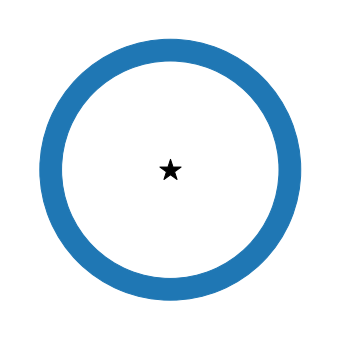

In [54]:
import matplotlib.patches as patches
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(0, 0, marker='*', color='black', s=500)
ring_outer_radius = 1.2
ring_inner_radius = 1.0
ring = patches.Wedge(center=(0, 0), r=ring_outer_radius, theta1=0, theta2=360, width=ring_outer_radius-ring_inner_radius, color='tab:blue')
ax.add_patch(ring)
ax.set_aspect('equal', 'box')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off') 
plt.show()

Now that you have all of the fibers that you want, let's put them all together for further processing, note that you can do this in different ways. We basically take all the ~830 shots, we merge all the detect ids in the shots, and the end product is a single pickle file which include all the fibers from all the LAEs in a certain region. all you need to do is uncommenting the last line, make sure you change the paths of the files accordingly.

In [37]:
def merge_files_for_radii(radius_in, radius_out):
    all_waves = []
    all_flux_densities = []
    all_flux_err = []
    search_pattern = f'zstore/fiber_spectra_newway_*_{radius_in}_{radius_out}.pickle'
    pickle_files = glob.glob(search_pattern)
    for filename in pickle_files:
        with open(filename, 'rb') as f:
            waves, flux_densities, flux_err = pickle.load(f)
            all_waves.extend(waves)
            all_flux_densities.extend(flux_densities)
            all_flux_err.extend(flux_err)
            if not waves or not flux_densities or not flux_err:
                print(f"Warning: Empty results in file {filename}.")
    output_filename = f'zslurm/valid_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(output_filename, 'wb') as f:
        pickle.dump((all_waves, all_flux_densities, all_flux_err), f)
        
#merge_files_for_radii(35, 55)

Ok, now it's time to stack all of the fibers in from all of the LAE. Again remember, you won't see much after the stakcing if your sample is less that ~1000 LAEs. The code below gives stacks every fiber in the pickle file you created above. using exec is not the best practice in coding, but it was pretty straight forward for this case so I used it. Modify the code however you want, the main part of this whole process is the anullishot.py script which we did first.

In [ ]:
radii = [(35,55)]
for radius_in, radius_out in radii:
    input_filename = f'zslurm/valid_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(input_filename, 'rb') as f:
        all_waves, all_flux_densities, all_flux_err = pickle.load(f)
    all_waves_2d = np.vstack([wave[0] for wave in all_waves])
    all_flux_densities_2d = np.vstack([flux[0] for flux in all_flux_densities])
    all_flux_err_2d = np.vstack([err[0] for err in all_flux_err])
    fluxes = all_flux_densities_2d
    waves = all_waves_2d
    flux_errs = all_flux_err_2d
    stack_flux_var = f'stack_flux_{radius_in}to{radius_out}_ffsky'
    stack_flux_err_var = f'stack_flux_err_{radius_in}to{radius_out}_ffsky'
    grid_var = f'grid_{radius_in}to{radius_out}_ffsky'
    contrib_count_var = f'contrib_count_{radius_in}to{radius_out}_ffsky'
    std_dev_var = f'std_dev_{radius_in}to{radius_out}_ffsky'
    exec(f"{stack_flux_var}, {stack_flux_err_var}, {grid_var}, {contrib_count_var}, {std_dev_var} = SU.stack_spectra(fluxes, flux_errs, waves, grid=None, avg_type='weighted_biweight', straight_error=False, std=True)")
    output_filename = f'zslurm/stacked_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(output_filename, 'wb') as f:
        exec(f"pickle.dump(({grid_var}, {stack_flux_var}, {stack_flux_err_var}, {contrib_count_var}, {std_dev_var}), f)")

Ok let's take a look at our stacked spectrum:

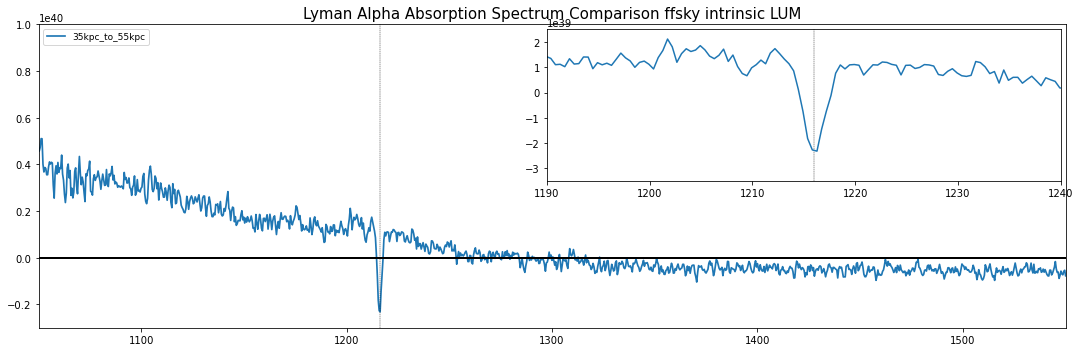

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

radii= [(35,55)]
plt.figure(figsize=(15,5))
ax_main = plt.gca()
ax_main.set_xlim(1050,1550)
ax_main.set_ylim(-0.3e40,1e40)
for idx, (radius_in, radius_out) in enumerate(radii):
    filename = f'zslurm/stacked_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(filename, 'rb') as f:
        grid, stack_flux, _, _, _ = pickle.load(f)
    ax_main.plot(grid, stack_flux, linewidth=1.7, label=f'{radius_in}kpc_to_{radius_out}kpc')
ax_main.axvline(x=1216, color='black', linestyle='dashed', linewidth=0.4)
ax_main.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax_main.set_title('Lyman Alpha Absorption Spectrum Comparison ffsky intrinsic LUM', fontsize=15)
ax_main.legend(loc='upper left' , fontsize=9)
ax_main.tick_params(axis='both', which='major', labelsize=10)
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper right")
ax_inset.axvline(x=1216, color='black', linestyle='dashed', linewidth=0.4)
for idx, (radius_in, radius_out) in enumerate(radii):
    filename = f'zslurm/stacked_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(filename, 'rb') as f:
        grid, stack_flux, _, _, _ = pickle.load(f)
    ax_inset.plot(grid, stack_flux, linewidth=1.5)
ax_inset.set_xlim(1190,1240)
ax_inset.set_ylim(-0.35e40,0.25e40)
plt.tight_layout()
plt.show()

Not bad! We have a strong absorption at the Lyman Alpha wavelength which shows us that the HI gas absorbs the UV Background light which is in our line of sight. This is only ~45 kpc away from the center of our LAEs, let's see how it changes if we look at further region of the CGM of the LAEs:

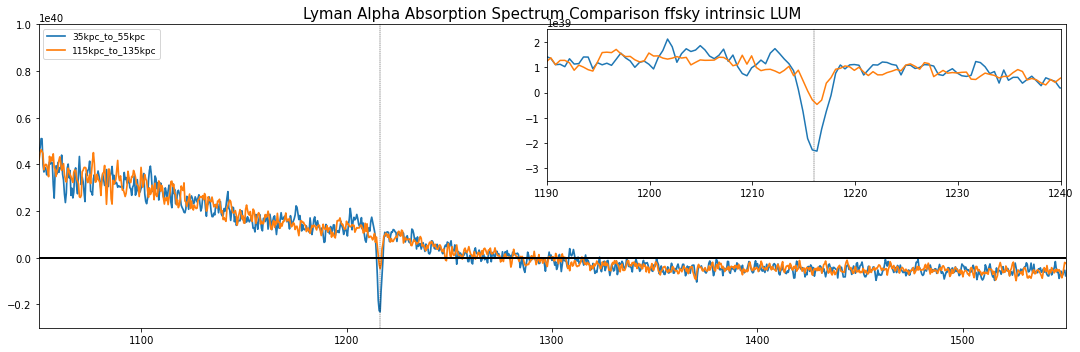

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

radii= [(35,55),(115,135)]
plt.figure(figsize=(15,5))
ax_main = plt.gca()
ax_main.set_xlim(1050,1550)
ax_main.set_ylim(-0.3e40,1e40)
for idx, (radius_in, radius_out) in enumerate(radii):
    filename = f'zslurm/stacked_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(filename, 'rb') as f:
        grid, stack_flux, _, _, _ = pickle.load(f)
    ax_main.plot(grid, stack_flux, linewidth=1.7, label=f'{radius_in}kpc_to_{radius_out}kpc')
ax_main.axvline(x=1216, color='black', linestyle='dashed', linewidth=0.4)
ax_main.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax_main.set_title('Lyman Alpha Absorption Spectrum Comparison ffsky intrinsic LUM', fontsize=15)
ax_main.legend(loc='upper left' , fontsize=9)
ax_main.tick_params(axis='both', which='major', labelsize=10)
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper right")
ax_inset.axvline(x=1216, color='black', linestyle='dashed', linewidth=0.4)
for idx, (radius_in, radius_out) in enumerate(radii):
    filename = f'zslurm/stacked_fibers_{radius_in}kpc_to_{radius_out}kpc_ffsky_slurm.pickle'
    with open(filename, 'rb') as f:
        grid, stack_flux, _, _, _ = pickle.load(f)
    ax_inset.plot(grid, stack_flux, linewidth=1.5)
ax_inset.set_xlim(1190,1240)
ax_inset.set_ylim(-0.35e40,0.25e40)
plt.tight_layout()
plt.show()

Interesting! We have less of an absorption. Now one might ask well does this mean that we have less background light or less HI gas in the CGM. The answer is kinda bit of both, but what is the contribution ratio of each is still something that I'm working on myself.

From here on, you can do the analysis by fitting this absorptions into a gaussian using curvefit or MCMC methods. And now, you have an estimate of the HI column density in different regions of the CGM of an average LAE. Note that I say average because this work clearly lacks data individuality because we stack A LOT of fibers to get to this. But even seeing this absorption is very exciting as it is almost impossible to detect it with most telescopes.

#### please don't hesitate to message me on Slack for any questions @Mahan Mirza Khanlari